# 0.0 Understanding the Situation

- objective of the proposed situation
1. Prediction of the first destination a new user will choose
- Why?
 - What kind of business model does Airbnb have?
 - Market Place (connecting people who offer accommodation with people who are looking for accommodation)
 - Offer (people offer accommodation)
   - Portifolio size
   - Portfolio diversity/density
   - Average price
 - Demand (people looking for accommodation)
   - Number of Users
   - LTV (Lifetime Value)
   - CAC (Client Acquisition Cost)
 - Gross Revenue  = fee * number of users - CAC (contribution margins)
 
 
- **Solution**
 - Prediction model of the first destination of a new user
 - API
   - **Input**: user and its characteristics
   - **Output**: user and its characteristics **with the prediction of destination**

# 1.0 IMPORTS

## 1.1 Libraries

In [116]:
#!pip install category_encoders

In [117]:
import random

import numpy  as np # pip install numpy
import pandas as pd  # pip install pandas

import seaborn as sns # pip install seaborn
import matplotlib.pyplot as plt

from scipy import stats as ss # pip install scipy

from sklearn.metrics         import accuracy_score, balanced_accuracy_score, cohen_kappa_score, classification_report
from sklearn.preprocessing   import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold  # pip install sklearn

from scikitplot.metrics      import plot_confusion_matrix  # pip install scikit-plot

from imblearn                import combine        as c # pip install imblearn
from imblearn                import over_sampling  as over
from imblearn                import under_sampling as us

from category_encoders       import TargetEncoder

from pandas_profiling        import ProfileReport # pip install pandas-profiling

from keras.models            import Sequential  # pip install keras; pip install tensorflow
from keras.layers            import Dense

## 1.2 Helper Functions

In [2]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))

## 1.3 Loading data

In [3]:
!ls -l ../01-Data/csv_data

total 648652
-rw-r--r-- 1 fabio 197609     11905 Oct 16  2015 age_gender_bkts.csv
-rw-r--r-- 1 fabio 197609       632 Oct 16  2015 countries.csv
-rw-r--r-- 1 fabio 197609    931451 Dec  6  2015 sample_submission_NDF.csv
-rw-r--r-- 1 fabio 197609 631646292 Dec  6  2015 sessions.csv
-rw-r--r-- 1 fabio 197609   6763170 May 16  2018 test_users.csv
-rw-r--r-- 1 fabio 197609  24853881 Dec 10  2015 train_users_2.csv


### 1.3.1 Training

In [4]:
df_train_raw = pd.read_csv(
    "../01-Data/csv_data/train_users_2.csv", low_memory=True)
df_train_raw.shape

(213451, 16)

### 1.3.2 Sessions

In [5]:
df_sessions_raw = pd.read_csv(
    "../01-Data/csv_data/sessions.csv", low_memory=True)
df_sessions_raw.shape

(10567737, 6)

# 2.0 DATA DESCRIPTION

In [6]:
df_train_01 = df_train_raw.copy()
df_sessions_01 = df_sessions_raw.copy()

## 2.1 Data Dimensions

### 2.1.1 Training

In [7]:
print(f'Number of Rows: {df_train_01.shape[0]}')
print(f'Number of Columns: {df_train_01.shape[1]}')

Number of Rows: 213451
Number of Columns: 16


### 2.1.2 Sessions

In [8]:
print(f'Number of Rows: {df_sessions_01.shape[0]}')
print(f'Number of Columns: {df_sessions_01.shape[1]}')

Number of Rows: 10567737
Number of Columns: 6


## 2.2 Data Type

### 2.2.1 Training

In [9]:
df_train_01.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

### 2.2.2 Sessions

In [10]:
df_sessions_01.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

## 2.3 NA Check

### 2.3.1 Training

In [11]:
df_train_01.isnull().sum() / len(df_train_01)

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

In [12]:
aux = df_train_01[df_train_01['date_first_booking'].isnull()]
aux['country_destination'].value_counts(normalize=True)

NDF    1.0
Name: country_destination, dtype: float64

In [13]:
aux = df_train_01[df_train_01['age'].isnull()]
aux['country_destination'].value_counts(normalize=True)

NDF      0.768428
US       0.156529
other    0.028617
FR       0.014888
IT       0.009081
GB       0.006251
ES       0.006171
CA       0.003989
DE       0.002387
NL       0.001818
AU       0.001171
PT       0.000671
Name: country_destination, dtype: float64

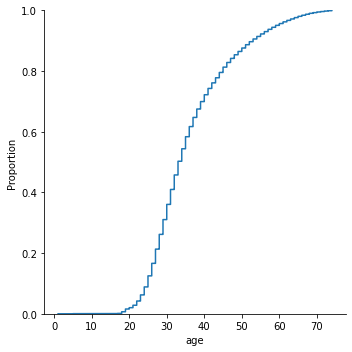

In [14]:
sns.displot(df_train_01[df_train_01['age']<75]['age'], kind='ecdf');

In [15]:
df_train_01['first_affiliate_tracked'].drop_duplicates()

0            untracked
5                  omg
12                 NaN
13              linked
79       tracked-other
257            product
6270         marketing
11184        local ops
Name: first_affiliate_tracked, dtype: object

In [16]:
# remove missing values completely
#df_train_01 = df_train_01.dropna()

# date_first_booking
date_first_booking_max = pd.to_datetime(df_train_01['date_first_booking']).max().strftime('%Y-%m-%d')
df_train_01['date_first_booking'] = df_train_01['date_first_booking'].fillna(date_first_booking_max)

# age
df_train_01 = df_train_01[(df_train_01['age'] > 15) & (df_train_01['age'] < 120)]
avg_age = int(df_train_01['age'].mean())
df_train_01['age'] = df_train_01['age'].fillna(avg_age)

# first_affiliate_tracked
# remove missing values completely
df_train_01 = df_train_01[~df_train_01['first_affiliate_tracked'].isnull()]

df_train_01.shape

(122636, 16)

### 2.3.2 Sessions

In [17]:
df_sessions_01.isnull().sum() / len(df_sessions_01)

user_id          0.003264
action           0.007535
action_type      0.106570
action_detail    0.106570
device_type      0.000000
secs_elapsed     0.012872
dtype: float64

In [18]:
# remove missing values completely
## user_id - 0.3%
df_sessions_01 = df_sessions_01[~df_sessions_01['user_id'].isnull()]

## action - 0.75%
df_sessions_01 = df_sessions_01[~df_sessions_01['action'].isnull()]

## action_type - 10.65%
df_sessions_01 = df_sessions_01[~df_sessions_01['action_type'].isnull()]

## action_detail - 10.65%
df_sessions_01 = df_sessions_01[~df_sessions_01['action_detail'].isnull()]

## secs_elapsed - 1.3%
df_sessions_01 = df_sessions_01[~df_sessions_01['secs_elapsed'].isnull()]

df_sessions_01.shape

(9213930, 6)

## 2.4 Change Data type 

### 2.4.1 Training

In [19]:
# date_account_created
df_train_01['date_account_created'] = pd.to_datetime(
    df_train_01['date_account_created'])
# timestamp_first_active
df_train_01['timestamp_first_active'] = pd.to_datetime(
    df_train_01['timestamp_first_active'], format='%Y%m%d%H%M%S')
# date_first_booking
df_train_01['date_first_booking'] = pd.to_datetime(
    df_train_01['date_first_booking'])

# age
df_train_01['age'] = df_train_01['age'].astype(int)

In [20]:
df_train_01.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int32
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

## 2.5 Check Balanced Data

### 2.5.1 Training

In [21]:
df_train_01['country_destination'].value_counts(normalize=True)

NDF      0.447275
US       0.391867
other    0.061246
FR       0.029918
IT       0.016423
GB       0.014335
ES       0.013740
CA       0.008676
DE       0.006858
NL       0.004852
AU       0.003531
PT       0.001280
Name: country_destination, dtype: float64

## 2.6 Descriptive Analysis

### 2.6.1 General

In [22]:
## Users
num_attributes = df_train_01.select_dtypes(include=['int32', 'int64', 'float64'])
cat_attributes = df_train_01.select_dtypes(exclude=['int32','int64', 'float64', 'datetime64[ns]'])
time_attributes = df_train_01.select_dtypes(include=['datetime64[ns]'])

## Sessions
num_attributes_sessions = df_sessions_01.select_dtypes(include=['int32', 'int64', 'float64'])
cat_attributes_sessions = df_sessions_01.select_dtypes(exclude=['int32','int64', 'float64', 'datetime64[ns]'])
time_attributes_sessions = df_sessions_01.select_dtypes(include=['datetime64[ns]'])

### 2.6.2 Numerical Users

In [23]:
# Central Tendency - Mean, Mediam
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersions - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
                  
# Concatenate
ct = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,16.0,115.0,99.0,37.405591,34.0,13.939844,2.089718,6.516468
1,signup_flow,0.0,25.0,25.0,2.519513,0.0,6.604696,2.705871,5.928298


### 2.6.3 Numerical Sessions

In [24]:
# Central Tendency - Mean, Mediam
ct1 = pd.DataFrame(num_attributes_sessions.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes_sessions.apply(np.median)).T

# Dispersions - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes_sessions.apply(np.std)).T
d2 = pd.DataFrame(num_attributes_sessions.apply(min)).T
d3 = pd.DataFrame(num_attributes_sessions.apply(max)).T
d4 = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.kurtosis())).T

# Concatenate
ct = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,secs_elapsed,0.0,1799977.0,1799977.0,19961.8251,1369.0,88849.388449,11.137761,154.84312


### 2.6.3 Categorical Users

In [25]:
cat_attributes.drop('id', axis=1).describe()

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,122636,122636,122636,122636,122636,122636,122636,122636,122636,122636
unique,4,3,25,8,17,7,4,9,41,12
top,FEMALE,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,56362,66039,118205,79093,78954,64712,108283,57943,41778,54852


### 2.6.4 Categorical Sessions

In [26]:
cat_attributes_sessions.drop('user_id', axis=1).describe()

,action,action_type,action_detail,device_type
count,9213930,9213930,9213930,9213930
unique,347,10,155,14
top,show,view,view_search_results,Mac Desktop
freq,2178382,3545621,1770931,3019523


In [27]:
# list of attributes for Cramer's V correlation
cat_attributes_list = cat_attributes_sessions.drop('user_id', axis=1).columns.tolist()

corr_dict = {}
for i in range(len(cat_attributes_list)):
    corr_list = []
    for j in range(len(cat_attributes_list)):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        # correlation
        corr = cramer_v(cat_attributes_sessions[ref], cat_attributes_sessions[feat])
        
        # append list
        corr_list.append(corr)
        
    # append correlation list for each ref attributes  
    corr_dict[ref] = corr_list
    
#d = pd.DataFrame(corr_dict)

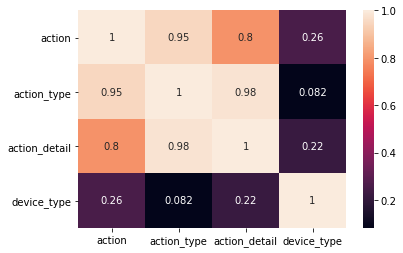

In [28]:
d = pd.DataFrame(corr_dict)
d = d.set_index(d.columns)
sns.heatmap(d, annot=True);

# 3.0 Feature Engineering

In [29]:
df_train_02 = df_train_01.copy()
df_sessions_02 = df_sessions_01.copy()

In [30]:
# days from first activate up to first booking
df_train_02['first_active'] = pd.to_datetime(
    df_train_02['timestamp_first_active'].dt.strftime('%Y-%m-%d'))
df_train_02['days_from_first_active_until_booking'] = (
    df_train_02['date_first_booking'] - df_train_02['first_active']).apply(lambda x: x.days)

# days from first activate up to account created
df_train_02['days_from_first_active_until_account_created'] = (
    df_train_02['date_account_created'] - df_train_02['first_active']).apply(lambda x: x.days)

# days from account created up to first booking
df_train_02['days_from_account_created_until_first_booking'] = (
    df_train_02['date_first_booking'] - df_train_02['date_account_created']).apply(lambda x: x.days)


# =============================== first active ===============================
# year first active
df_train_02['year_first_active'] = df_train_02['first_active'].dt.year

# month first active
df_train_02['month_first_active'] = df_train_02['first_active'].dt.month

# day first active
df_train_02['day_first_active'] = df_train_02['first_active'].dt.day

# day of week first active
df_train_02['day_of_week_first_active'] = df_train_02['first_active'].dt.dayofweek

# week of year of first active
df_train_02['week_of_year_first_active'] = df_train_02['first_active'].dt.weekofyear


# =============================== first booking ===============================
# year first booking
df_train_02['year_first_booking'] = df_train_02['date_first_booking'].dt.year

# month first booking
df_train_02['month_first_booking'] = df_train_02['date_first_booking'].dt.month

# day first booking
df_train_02['day_first_booking'] = df_train_02['date_first_booking'].dt.day

# day of week first booking
df_train_02['day_of_week_first_booking'] = df_train_02['date_first_booking'].dt.dayofweek

# week of year of first booking
df_train_02['week_of_year_first_booking'] = df_train_02['date_first_booking'].dt.weekofyear


# =============================== first account created ===============================
# year first booking
df_train_02['year_account_created'] = df_train_02['date_account_created'].dt.year

# month first booking
df_train_02['month_account_created'] = df_train_02['date_account_created'].dt.month

# day first booking
df_train_02['day_account_created'] = df_train_02['date_account_created'].dt.day

# day of week first booking
df_train_02['day_of_week_account_created'] = df_train_02['date_account_created'].dt.dayofweek

# week of year of first booking
df_train_02['week_of_year_account_created'] = df_train_02['date_account_created'].dt.weekofyear

<ipython-input-30-e523a0ac8692>:30: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df_train_02['week_of_year_first_active'] = df_train_02['first_active'].dt.weekofyear
<ipython-input-30-e523a0ac8692>:47: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df_train_02['week_of_year_first_booking'] = df_train_02['date_first_booking'].dt.weekofyear
<ipython-input-30-e523a0ac8692>:64: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df_train_02['week_of_year_account_created'] = df_train_02['date_account_created'].dt.weekofyear


# 4.0 Data Filtering

In [31]:
df_train_03 = df_train_02.copy()
df_sessions_03 = df_sessions_02.copy()

## 4.1 Filtering Rows

In [32]:
# Filtering rows:
## age > greater than 15 and lower than 120 - There are few people over 120 years old
df_train_03 = df_train_03[(df_train_03['age'] > 15) & (df_train_03['age'] < 120)]

## secs_elapsed > greater than 0 - There is no possible secs elepsed on website
df_sessions_03 = df_sessions_03[df_sessions_03['secs_elapsed'] > 0]

## 4.1 Filtering Columns

In [33]:
cols = ['date_account_created', 'timestamp_first_active', 'date_first_booking', 'first_active'] # orginal Datetime
df_train_03 = df_train_03.drop(cols, axis=1)

# 5.0 Balanced Dataset

In [34]:
df_train_04 = df_train_03.copy()

In [35]:
# Encoder Categorical Variables
ohe = OneHotEncoder()

# Numerical
col_num = df_train_04.select_dtypes(include=['int32', 'int64', 'float64']).columns.tolist()

# Categorical
col_cat = df_train_04.select_dtypes(exclude=['int32', 'int64', 'float64', 'datetime64[ns]'])\
    .drop(['id', 'country_destination'], axis=1).columns.tolist()

# Encoding
df_train_04_dummy = pd.DataFrame(ohe.fit_transform(df_train_04[col_cat]).toarray(), index=df_train_04.index)

# join Numerical and Categorical
df_train_04_1 = pd.concat([df_train_04[col_num], df_train_04_dummy], axis=1)

## 5.1 Random Undersampling

In [36]:
# ratio balanced
ratio_balanced = {'NDF': 10000}

# define sampler
undersampling = us.RandomUnderSampler(sampling_strategy=ratio_balanced, random_state=32)

# apply sampler
X_under, y_under = undersampling.fit_resample(df_train_04_1, df_train_04['country_destination'])

In [37]:
df_train_04['country_destination'].value_counts()

NDF      54852
US       48057
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

In [38]:
y_under.value_counts()

US       48057
NDF      10000
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

## 5.2 Random Oversampling

In [39]:
# ratio balanced
#ratio_balanced = {'NDF': 10000}

# define sampler
oversampling = over.RandomOverSampler(sampling_strategy='all', random_state=32)

# apply sampler
X_over, y_over = oversampling.fit_resample(df_train_04_1, df_train_04['country_destination'])

In [40]:
df_train_04['country_destination'].value_counts()

NDF      54852
US       48057
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

In [41]:
y_over.value_counts()

IT       54852
NDF      54852
CA       54852
NL       54852
other    54852
AU       54852
PT       54852
US       54852
ES       54852
GB       54852
DE       54852
FR       54852
Name: country_destination, dtype: int64

## 5.3 SMOTE + TOMEKLINK

In [42]:
ratio_balanced = {
                    'NDF': 54852,
                    'US': 48057,
                    'other': 6*7511,
                    'FR': 12*3669,
                    'IT': 20*2014,
                    'GB': 25*1758,
                    'ES': 25*1685,
                    'CA': 40*1064,
                    'DE': 45*841,
                    'NL': 80*595,
                    'AU': 85*433,
                    'PT': 250*157}

In [43]:
# define sampler
smt = c.SMOTETomek(sampling_strategy=ratio_balanced, random_state=32, n_jobs=-1)

# apply sampler
X_smt, y_smt = smt.fit_resample(df_train_04_1, df_train_04['country_destination'])

In [44]:
# numerical data
df_train_04_2 = X_smt[col_num]

# categorical data
df_train_04_3 = X_smt.drop(col_num, axis=1)
df_train_04_4 = pd.DataFrame(ohe.inverse_transform(df_train_04_3), columns=col_cat, index=df_train_04_3.index)

# join numerical and categorical
df_train_04_6 = pd.concat([df_train_04_2, df_train_04_4], axis=1)
df_train_04_6['country_destination'] = y_smt

In [45]:
df_train_04['country_destination'].value_counts()

NDF      54852
US       48057
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

In [46]:
y_smt.value_counts()

NDF      54850
NL       47598
US       47525
other    44744
GB       43895
FR       43869
CA       42542
ES       42071
IT       40200
PT       39250
DE       37828
AU       36802
Name: country_destination, dtype: int64

# 6.0 Exploratory Data Analysis (EDA)

In [60]:
df_train_05_1 = df_train_04_6.copy()
df_train_05_2 = df_train_04.copy()

## 6.1 Univariate Analysis - Feature Bahaviour (Balanced Dataset)

In [59]:
profile = ProfileReport(df_train_05_1, title="Airbnb First Booking", html={'style': {'full_width':True}}, minimal=True)

profile.to_file(output_file='airbnb_booking.html')

## 6.2 Bivariate Analysis - Hypothesis Validation (Unbalanced dataset)

> - **H01** - At all destinations, it takes users 15 days on average to make their first Airbnb reservation since their first activation
> - **H02** - In all destinations, users take 3 days, on average, to register on the site
> - **H03** - The volume of annual reservations made during the summer increased by 20% for destinations within the US
> - **H04** - Female users make 10% more reservations for countries outside the US
> - **H05** - The Google Marketing channel accounts for 40% of reservations for countries outside the US
> - **H06** - The US target represents more than 20% on all channels
> - **H07** - The average age of people is 35 years in all destinations
> - **H08** - The percentage of users who use the site in the English American language to book accommodation in any destination is greater than 90%
> - **H09** - Is the number of Airbnb reservations increasing or decreasing over the years?
> - **H10** - The number of Airbnb reservations is increasing over the years

**H01** - At all destinations, it takes users 15 days on average to make their first Airbnb reservation since their first activation
> - **True:** At all destinations, it takes users up to 6 days to book the first Airbnb

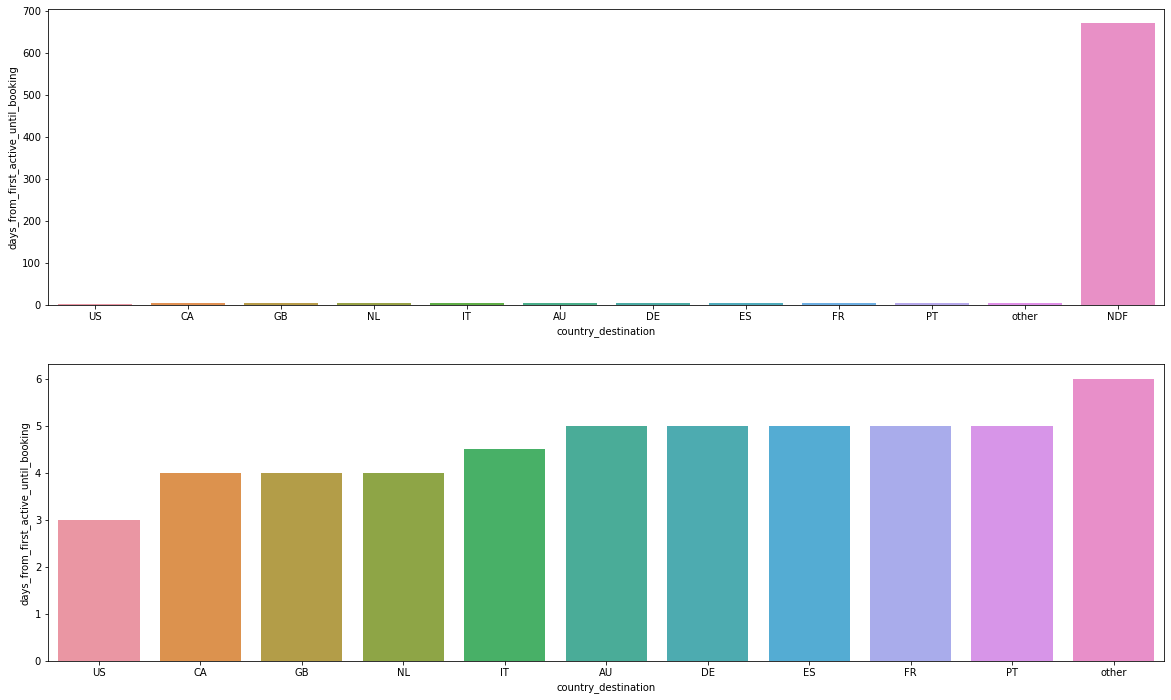

In [74]:
plt.figure(figsize=(20,12))

plt.subplot(2,1,1)
aux01 = df_train_05_2[['days_from_first_active_until_booking', 'country_destination']].groupby('country_destination').median().reset_index()
sns.barplot(x='country_destination', y='days_from_first_active_until_booking',
            data=aux01. sort_values('days_from_first_active_until_booking'));

# remove outlier
aux02 = df_train_05_2[df_train_05_2['country_destination'] != 'NDF']
aux02 = aux02[['days_from_first_active_until_booking', 'country_destination']].groupby('country_destination').median().reset_index()

plt.subplot(2,1,2)
sns.barplot(x='country_destination', y='days_from_first_active_until_booking',
            data=aux02. sort_values('days_from_first_active_until_booking'));

**H02** - In all destinations, users take 3 days, on average, to register on the site
> - **True:** In all destinations, users take, on average, up to 2 days to complete the registration 

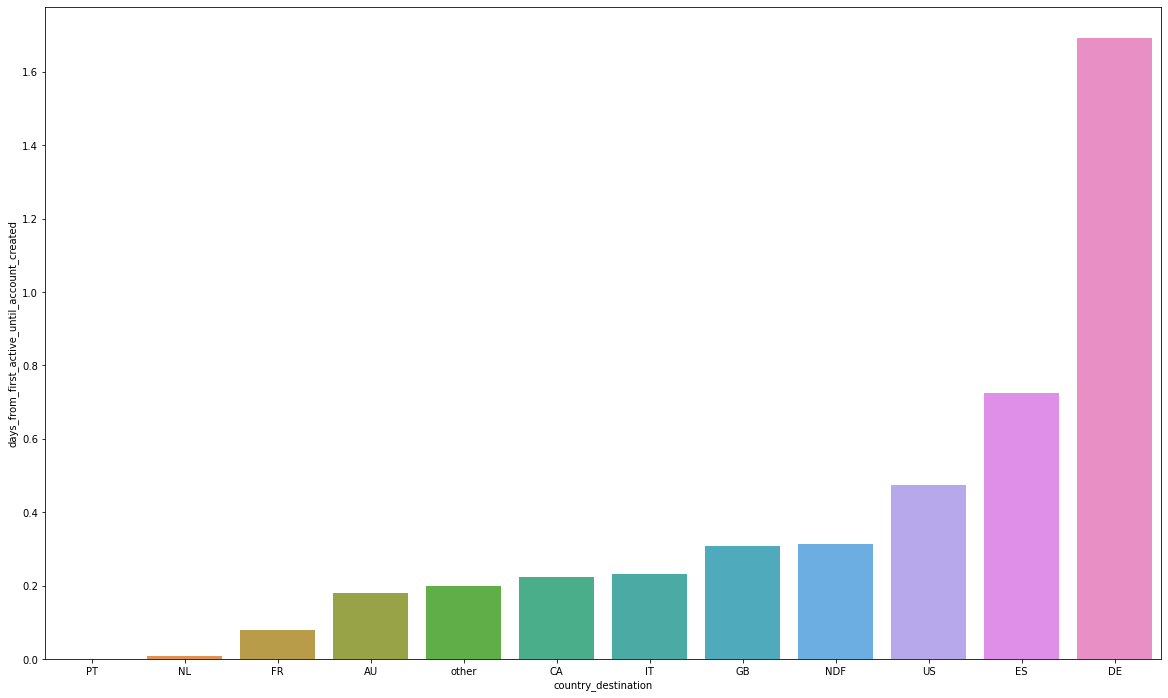

In [84]:
plt.figure(figsize=(20,12))

#plt.subplot(2,1,1)
aux01 = df_train_05_2[['days_from_first_active_until_account_created', 'country_destination']].groupby('country_destination').mean().reset_index()
sns.barplot(x='country_destination', y='days_from_first_active_until_account_created',
            data=aux01. sort_values('days_from_first_active_until_account_created'));

# # remove outlier
# aux02 = df_train_05_2[df_train_05_2['country_destination'] != 'NDF']
# aux02 = aux02[['days_from_first_active_until_account_created', 'country_destination']].groupby('country_destination').mean().reset_index()

# plt.subplot(2,1,2)
# sns.barplot(x='country_destination', y='days_from_first_active_until_account_created',
#             data=aux02. sort_values('days_from_first_active_until_account_created'));

**H03** - The volume of annual reservations made during the summer increased by 20% for destinations within the US
> - **FALSE:**  The volume of reserves increases during the summer between the years 2010 to 2013

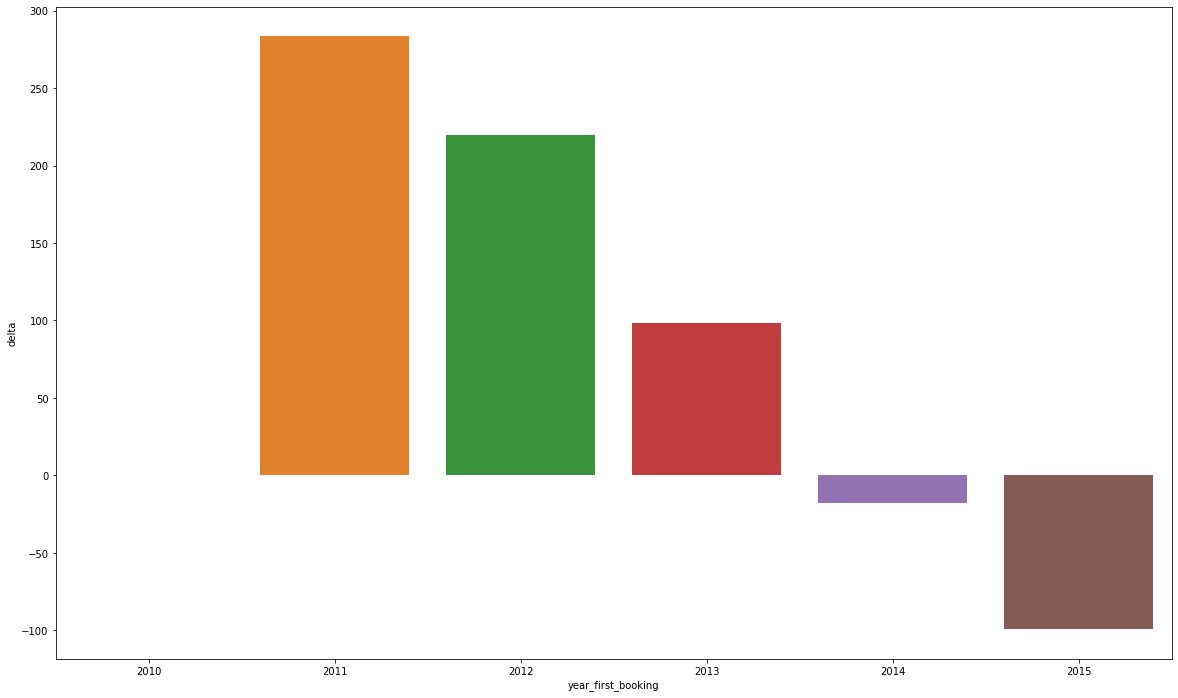

In [86]:
aux01 = df_train_05_2[['year_first_booking', 'month_first_booking', 'country_destination']].\
        groupby(['year_first_booking', 'month_first_booking', 'country_destination']).\
        size().reset_index().rename(columns={0: 'count'})

# select only summer 
aux01 = aux01[(aux01['month_first_booking'].isin([6, 7, 8, 9])) & (aux01['country_destination'] == 'US')]

aux02 = aux01[['year_first_booking', 'count']].groupby('year_first_booking').sum().reset_index()

aux02['delta'] = 100*aux02['count'].pct_change().fillna(0)

plt.figure(figsize=(20,12))
sns.barplot(x='year_first_booking', y='delta', data=aux02);

## 6.3 Multivariable analysis (Balanced Dataset)

In [89]:
## Users
num_attributes = df_train_05_1.select_dtypes(include=['int32', 'int64', 'float64'])
cat_attributes = df_train_05_1.select_dtypes(exclude=['int32','int64', 'float64', 'datetime64[ns]'])

### 6.3.1 Numerical

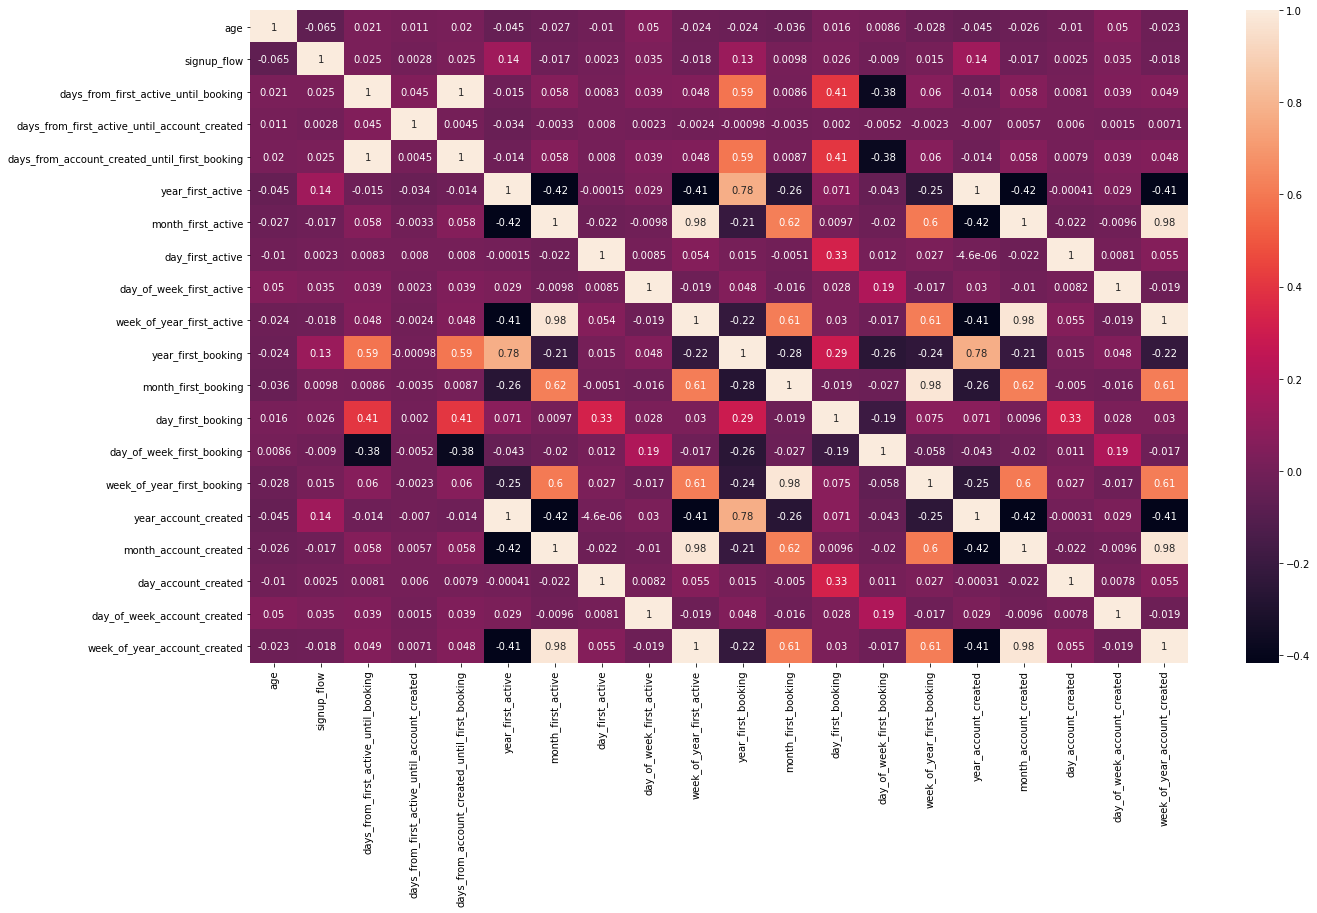

In [90]:
correlation = num_attributes.corr(method='pearson')
plt.figure(figsize=(21,12))
sns.heatmap(correlation, annot=True);

### 6.3.2 Categorical

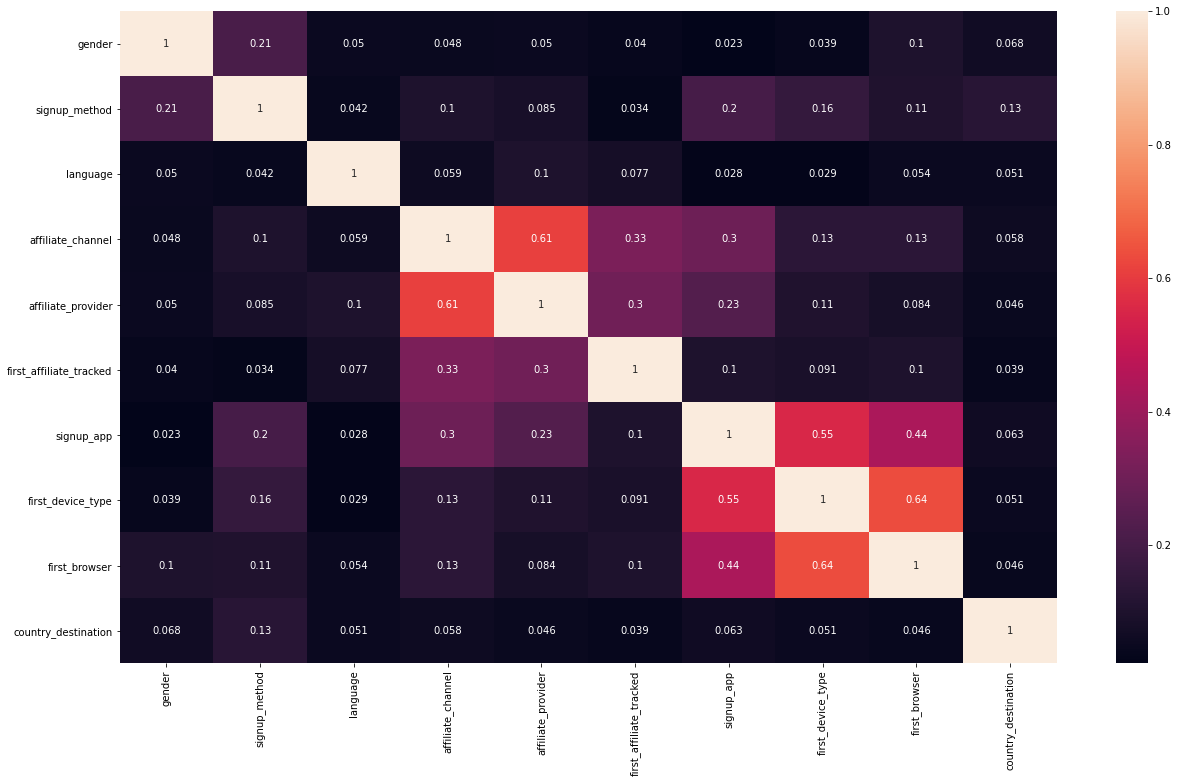

In [91]:
# list of attributes for Cramer's V correlation
cat_attributes_list = cat_attributes.columns.tolist()

corr_dict = {}
for i in range(len(cat_attributes_list)):
    corr_list = []
    for j in range(len(cat_attributes_list)):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        # correlation
        corr = cramer_v(cat_attributes[ref], cat_attributes[feat])
        
        # append list
        corr_list.append(corr)
        
    # append correlation list for each ref attributes  
    corr_dict[ref] = corr_list
    
d = pd.DataFrame(corr_dict)
d = d.set_index(d.columns)
plt.figure(figsize=(21,12))
sns.heatmap(d, annot=True);

# 7.0 Data Filtering 2

## 7.1 Filtering Columns

In [108]:
# ============================== High Correlation ==============================
# days_from_first_active_until_booking x days_from_account_created_until_first_booking
# remove: days_from_first_active_until_booking

# year_first_active x year_account_created
# remove: year_first_active

# month_first_active x month_account_created
# remove:month_first_active

# day_first_active x day_account_created
# remove:day_first_active

# day_of_week_first_active x day_of_week_account_created
# remove: day_of_week_first_active

# week_of_year_first_active x week_of_year_account_created
# remove: week_of_year_first_active

# month_first_active x week_of_year_account_created
# remove: month_first_active

# month_first_active x week_of_year_first_active
# remove: month_first_active

# week_of_year_first_active x month_account_created
# remove: week_of_year_first_active

# month_first_booking x week_of_year_first_booking
# remove: month_first_booking

# month_account_created x week_of_year_account_created
# remove: month_account_created

# month_account_created x week_of_year_account_created
# remove: month_account_created

# year_first_booking x year_account_created
# remove: year_first_booking

# week_of_year_first_booking x week_of_year_account_created
# remove: week_of_year_first_booking


# affiliate_channel x affiliate_provider
# remove: affiliate_provider

# first_device_type x first_browser
# remove: first_browser

# first_device_type x signup_app
# remove: first_device_type


cols_to_drop = ['days_from_first_active_until_booking','year_first_active','month_first_active','day_first_active',
'day_of_week_first_active','week_of_year_first_active','month_first_booking','month_account_created',
'year_first_booking','week_of_year_first_booking','affiliate_provider','first_browser','first_device_type', 'language']

df_train_07 = df_train_05_1.drop(cols_to_drop, axis=1)

# 8.0 Data Preparation

In [121]:
df_train_08 = df_train_07.copy()

In [122]:
# # Dummy variable
# df_train_08_dummy = pd.get_dummies(
#     df_train_08.drop(['country_destination'], axis=1))

# # Join id and country_destination
# df_train_08 = pd.concat(
#     [df_train_08[['country_destination']], df_train_08_dummy], axis=1)

## 8.1 Rescaling

In [123]:
ss = StandardScaler()
rs = RobustScaler()
mms = MinMaxScaler()

# =========================== Standardization ===========================
# age
df_train_08['age'] = ss.fit_transform(df_train_08[['age']].values)


# =========================== Robust Sacaler ===========================
# signup_flow
df_train_08['signup_flow'] = rs.fit_transform(df_train_08[['signup_flow']].values)

# days_from_first_active_until_account_created
df_train_08['days_from_first_active_until_account_created'] = rs.fit_transform(df_train_08[['days_from_first_active_until_account_created']].values)

# days_from_account_created_until_first_booking
df_train_08['days_from_account_created_until_first_booking'] = rs.fit_transform(df_train_08[['days_from_account_created_until_first_booking']].values)

# =========================== MinMax Sacaler ===========================

# year_account_created
df_train_08['year_account_created'] = mms.fit_transform(df_train_08[['year_account_created']].values)

## 8.2 Encoding

In [124]:
te = TargetEncoder()

# =========================== One Hot Encoder ===========================
# gender
df_train_08 = pd.get_dummies(df_train_08, prefix=['gender'], columns=['gender'])

# signup_method
df_train_08 = pd.get_dummies(df_train_08, prefix=['signup_method'], columns=['signup_method'])

# signup_app
df_train_08 = pd.get_dummies(df_train_08, prefix=['signup_app'], columns=['signup_app'])


# =========================== Target Encoder ===========================
c = {'NDF': 0,'US': 1,'other': 2,'CA': 3,'FR': 4,'IT': 5,'ES': 6,'GB': 7,'NL': 8,'DE': 9,'AU': 10,'PT':11}

# first_affiliate_tracked
df_train_08['first_affiliate_tracked'] = te.fit_transform(df_train_08[['first_affiliate_tracked']].values, df_train_08['country_destination'].map(c))

# affiliate_channel
df_train_08['affiliate_channel'] = te.fit_transform(df_train_08[['affiliate_channel']].values, df_train_08['country_destination'].map(c))

C:\Users\fabio\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\fabio\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


## 8.3 Transformation

In [125]:
# week_of_year_account_created
df_train_08['week_of_year_account_created_sin'] = df_train_08['week_of_year_account_created'].apply(lambda x: np.sin(x * (2*np.pi/52)))
df_train_08['week_of_year_account_created_cos'] = df_train_08['week_of_year_account_created'].apply(lambda x: np.cos(x * (2*np.pi/52)))

# day_of_week_account_created
df_train_08['day_of_week_account_created_sin'] = df_train_08['day_of_week_account_created'].apply(lambda x: np.sin(x * (2*np.pi/7)))
df_train_08['day_of_week_account_created_cos'] = df_train_08['day_of_week_account_created'].apply(lambda x: np.cos(x * (2*np.pi/7)))

# day_of_week_first_booking
df_train_08['day_of_week_first_booking_sin'] = df_train_08['day_of_week_first_booking'].apply(lambda x: np.sin(x * (2*np.pi/7)))
df_train_08['day_of_week_first_booking_cos'] = df_train_08['day_of_week_first_booking'].apply(lambda x: np.cos(x * (2*np.pi/7)))

# day_account_created
df_train_08['day_account_created_sin'] = df_train_08['day_account_created'].apply(lambda x: np.sin(x * (2*np.pi/31)))
df_train_08['day_account_created_cos'] = df_train_08['day_account_created'].apply(lambda x: np.cos(x * (2*np.pi/31)))

# 9.0 Feature Selection

In [126]:
# cols_drop = ['id']
# df_train_06 = df_train_05.drop(cols_drop, axis=1)
df_train_09 = df_train_08.copy()

## 9.1 Split into Train and Validation 

In [127]:
X = df_train_09.drop('country_destination', axis=1)
y = df_train_09['country_destination'].copy()

# Split dataset into train and validation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=32)

# 10.0 Machine Learning Model

## 10.1 Baseline model

### 10.1.1 Random Choices

In [128]:
country_destination_list = y_train.drop_duplicates().sort_values().tolist()
country_destination_weights = y_train.value_counts(
    normalize=True).sort_index().tolist()
k_num = y_test.shape[0]

# Random Model

yhat_random = random.choices(population=country_destination_list,
                             weights=country_destination_weights,
                             k=k_num)

### 10.1.2 Random Choices Performance

Accuracy: 0.08264018803664797
Balanced Accuracy: 0.08169024683512284
Kappa Score: -0.0018641203084088787
              precision    recall  f1-score   support

          AU       0.07      0.07      0.07      7482
          CA       0.08      0.08      0.08      8419
          DE       0.07      0.07      0.07      7454
          ES       0.08      0.07      0.08      8390
          FR       0.08      0.08      0.08      8828
          GB       0.08      0.08      0.08      8741
          IT       0.07      0.07      0.07      7961
         NDF       0.10      0.10      0.10     10939
          NL       0.09      0.09      0.09      9526
          PT       0.07      0.07      0.07      7942
          US       0.09      0.09      0.09      9519
       other       0.09      0.08      0.09      9034

    accuracy                           0.08    104235
   macro avg       0.08      0.08      0.08    104235
weighted avg       0.08      0.08      0.08    104235



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

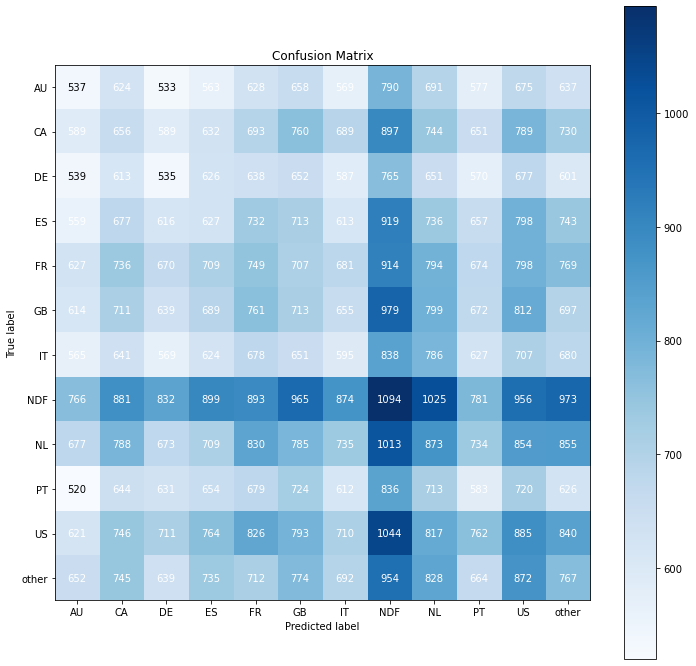

In [129]:
# Accuracy
acc_random = accuracy_score(y_test, yhat_random)
print('Accuracy: {}'.format(acc_random))

# Balanced Accuracy
balanced_acc_random = balanced_accuracy_score(y_test, yhat_random)
print('Balanced Accuracy: {}'.format(balanced_acc_random))

# Kappa Score
kappa_random = cohen_kappa_score(y_test, yhat_random)
print('Kappa Score: {}'.format(kappa_random))

# Classification Report
print(classification_report(y_test, yhat_random))

# Confusion matrix
plot_confusion_matrix(y_test, yhat_random, normalize=False, figsize=(12, 12))

## 10.2 Machine Learning Model - Neural Network MLP

### 10.2.1 Target Encoding

In [130]:
ohe = OneHotEncoder()
y_train_nn = ohe.fit_transform(y_train.values.reshape(-1, 1)).toarray()

### 10.2.2 NN Model

In [132]:
# Model Definition
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(12, activation='softmax'))

# Model compile
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

# Train Model
model.fit(X_train, y_train_nn, epochs=100)

Epoch 1/100
13030/13030 [==============================] - 15s 1ms/step - loss: 2.1373 - accuracy: 0.2448
Epoch 2/100
13030/13030 [==============================] - 15s 1ms/step - loss: 1.9171 - accuracy: 0.3250
Epoch 3/100
13030/13030 [==============================] - 15s 1ms/step - loss: 1.8293 - accuracy: 0.3617
Epoch 4/100
13030/13030 [==============================] - 15s 1ms/step - loss: 1.7799 - accuracy: 0.3781
Epoch 5/100
13030/13030 [==============================] - 14s 1ms/step - loss: 1.7485 - accuracy: 0.3898
Epoch 6/100
13030/13030 [==============================] - 14s 1ms/step - loss: 1.7283 - accuracy: 0.3965
Epoch 7/100
13030/13030 [==============================] - 14s 1ms/step - loss: 1.7104 - accuracy: 0.4023
Epoch 8/100
13030/13030 [==============================] - 14s 1ms/step - loss: 1.6974 - accuracy: 0.4078
Epoch 9/100
13030/13030 [==============================] - 14s 1ms/step - loss: 1.6846 - accuracy: 0.4126
Epoch 10/100
13030/13030 [====================

13030/13030 [==============================] - 8s 600us/step - loss: 1.5674 - accuracy: 0.4536
Epoch 78/100
13030/13030 [==============================] - 8s 603us/step - loss: 1.5634 - accuracy: 0.4538
Epoch 79/100
13030/13030 [==============================] - 8s 601us/step - loss: 1.5662 - accuracy: 0.4538
Epoch 80/100
13030/13030 [==============================] - 8s 596us/step - loss: 1.5650 - accuracy: 0.4546
Epoch 81/100
13030/13030 [==============================] - 8s 599us/step - loss: 1.5603 - accuracy: 0.4558
Epoch 82/100
13030/13030 [==============================] - 8s 602us/step - loss: 1.5640 - accuracy: 0.4549
Epoch 83/100
13030/13030 [==============================] - 8s 598us/step - loss: 1.5605 - accuracy: 0.4556
Epoch 84/100
13030/13030 [==============================] - 8s 601us/step - loss: 1.5604 - accuracy: 0.4554
Epoch 85/100
13030/13030 [==============================] - 8s 593us/step - loss: 1.5593 - accuracy: 0.4562
Epoch 86/100
13030/13030 [===============

### 10.2.3 NN Performance

In [133]:
# Prediction
pred_nn = model.predict(X_test)

# Inver Prediction
yhat_nn = ohe.inverse_transform(pred_nn)

# Prediction Prepare
y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape(1, -1)[0]

Accuracy: 0.45162373482995155
Balanced Accuracy: 0.44264262533749577
Kappa Score: 0.40097414093310346
              precision    recall  f1-score   support

          AU       0.54      0.69      0.60      7482
          CA       0.32      0.44      0.37      8419
          DE       0.42      0.35      0.38      7454
          ES       0.30      0.18      0.23      8390
          FR       0.19      0.20      0.20      8828
          GB       0.24      0.26      0.25      8741
          IT       0.29      0.13      0.18      7961
         NDF       1.00      1.00      1.00     10939
          NL       0.43      0.76      0.55      9526
          PT       0.67      0.96      0.79      7942
          US       0.32      0.26      0.28      9519
       other       0.23      0.08      0.12      9034

    accuracy                           0.45    104235
   macro avg       0.41      0.44      0.41    104235
weighted avg       0.42      0.45      0.42    104235



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

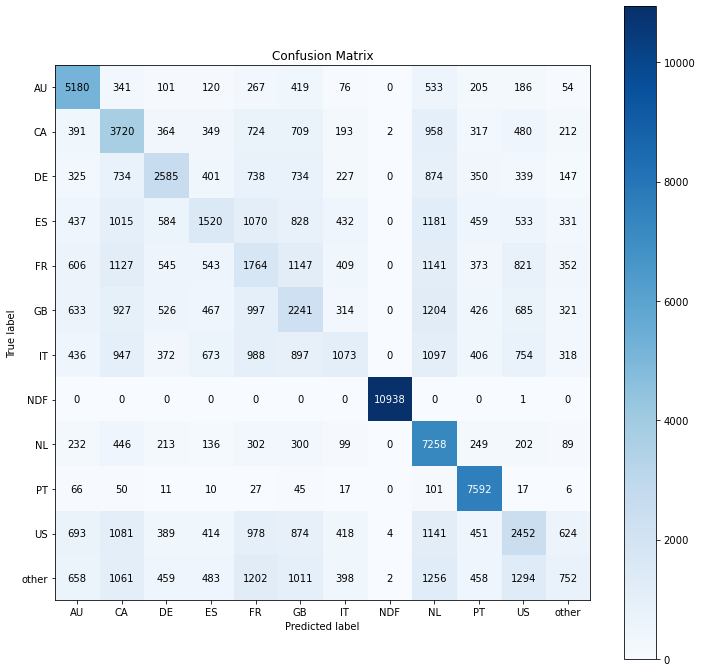

In [134]:
# Accuracy
acc_nn = accuracy_score(y_test_nn, yhat_nn)
print('Accuracy: {}'.format(acc_nn))

# Balanced Accuracy
balanced_acc_nn = balanced_accuracy_score(y_test_nn, yhat_nn)
print('Balanced Accuracy: {}'.format(balanced_acc_nn))

# Kappa Score
kappa_nn = cohen_kappa_score(y_test_nn, yhat_nn)
print('Kappa Score: {}'.format(kappa_nn))

# Classification Report
print(classification_report(y_test_nn, yhat_nn))

# Confusion matrix
plot_confusion_matrix(y_test_nn, yhat_nn, normalize=False, figsize=(12, 12))

### 10.2.4 NN Performance - Cross Validation

In [135]:
# k-fold generate
num_folds = 5
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=32)

balanced_acc_list = []
kappa_acc_list = []

i = 1
for train_ix, val_ix in kfold.split(X_train, y_train):
    print('Fold Number: {}/{}'.format(i, num_folds))
    # get fold
    X_train_fold = X_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]

    X_val_fold = X_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]

    # target encoding
    ohe = OneHotEncoder()
    y_train_fold_nn = ohe.fit_transform(
        y_train_fold.values.reshape(-1, 1)).toarray()

    # model definition
    model = Sequential()
    model.add(Dense(256, input_dim=X_train_fold.shape[1], activation='relu'))
    model.add(Dense(12, activation='softmax'))

    # compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', metrics=['accuracy'])

    # training model
    model.fit(X_train_fold, y_train_fold_nn,
              epochs=100, batch_size=32, verbose=0)

    # prediction
    pred_nn = model.predict(X_val_fold)
    yhat_nn = ohe.inverse_transform(pred_nn)

    # prepare data
    y_test_nn = y_val_fold.to_numpy()
    yhat_nn = yhat_nn.reshape(1, -1)[0]

    # metrics
    # Balanced Accuracy
    balanced_acc_nn = balanced_accuracy_score(y_test_nn, yhat_nn)
    balanced_acc_list.append(balanced_acc_nn)

    # Kappa Metrics
    kappa_acc_nn = cohen_kappa_score(y_test_nn, yhat_nn)
    kappa_acc_list.append(kappa_acc_nn)

    i += 1

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5


In [136]:
print('Avg Balanced Accuracy: {} +/- {}'.format(np.round(np.mean(balanced_acc_list), 4),
                                                np.round(np.std(balanced_acc_list), 4)))
print('Avg Kappa: {} +/- {}'.format(np.round(np.mean(kappa_acc_list), 4),
                                    np.round(np.std(kappa_acc_list), 4)))

Avg Balanced Accuracy: 0.4421 +/- 0.0042
Avg Kappa: 0.3983 +/- 0.0042
